### Import

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from numpy.linalg import qr, norm
import open3d as o3d

### Create 2D stanford bunny point cloud and normalize to [-1,1]

In [6]:
def slice_mesh_with_plane(mesh, plane_origin, plane_normal):
    """
    Slice a mesh with a plane and return the intersection points.
    :param mesh: open3d.geometry.TriangleMesh
    :param plane_origin: Origin of the slicing plane
    :param plane_normal: Normal vector of the slicing plane
    :return: numpy.ndarray of intersection points
    """
    # Create the plane equation: ax + by + cz + d = 0
    plane_normal = plane_normal / np.linalg.norm(plane_normal)
    d = -np.dot(plane_normal, plane_origin)

    # Collect intersection points
    intersection_points = []
    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)

    for triangle in triangles:
        # Get the vertices of the triangle
        v0, v1, v2 = vertices[triangle]

        # Check intersection of edges with the plane
        edges = [(v0, v1), (v1, v2), (v2, v0)]
        for edge in edges:
            p1, p2 = edge
            # Compute distances to the plane
            dist1 = np.dot(plane_normal, p1) + d
            dist2 = np.dot(plane_normal, p2) + d

            # If the edge intersects the plane
            if dist1 * dist2 < 0:  # Opposite signs => intersection
                t = dist1 / (dist1 - dist2)  # Parametric distance to intersection
                intersection_point = p1 + t * (p2 - p1)
                intersection_points.append(intersection_point)

    return np.array(intersection_points)

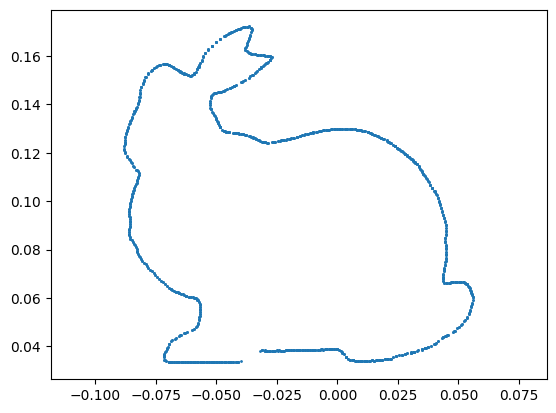

In [7]:
# Load the Stanford Bunny mesh
bunny = o3d.data.BunnyMesh()
mesh = o3d.io.read_triangle_mesh(bunny.path)
# mesh = mesh.subdivide_midpoint(number_of_iterations=1)
mesh.compute_vertex_normals()

# Define the slicing plane (e.g., z = 0.05)
plane_origin = np.array([0, 0, 0])  # A point on the plane
plane_normal = np.array([0, 0, 1])    # Plane normal (z-direction)

# Compute the intersection points
slice_points = slice_mesh_with_plane(mesh, plane_origin, plane_normal)

# Convert the slice to a 2D point cloud (x, y)
points = np.asarray(slice_points)
point_cloud_2d = points[:, :2]  # Ignore z-coordinate for 2D

# visualize the 2D point cloud
plt.figure()
plt.scatter(point_cloud_2d[:, 0], point_cloud_2d[:, 1], s=1)
plt.axis('equal')
plt.show()

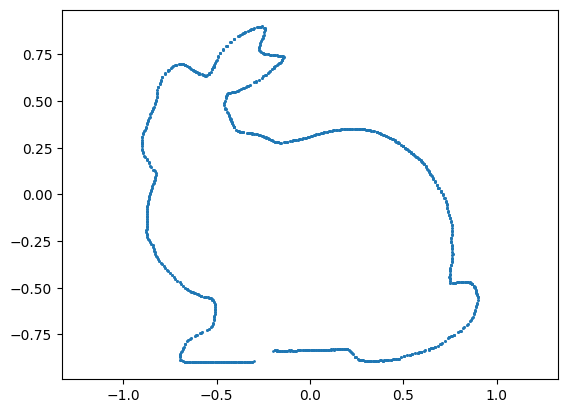

(1796, 2)


In [8]:
# Normalize the point cloud to [-1, 1]
pcl = point_cloud_2d
pcl = (pcl - pcl.min(axis=0)) / (pcl.max(axis=0) - pcl.min(axis=0))
pcl = 2 * pcl - 1
pcl = pcl * 0.9 # Scale the point cloud

# Visualize the normalized point cloud
plt.figure()
plt.scatter(pcl[:, 0], pcl[:, 1], s=1)
plt.axis('equal')
plt.show()

print(pcl.shape)


### Cholesky inverse version

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from scipy.linalg import cho_factor, cho_solve

def generate_monomials(X, degree):
    """
    Generate monomials up to a given degree for d-dimensional points.

    Parameters:
        X (ndarray): An array of shape (N, d) representing the point cloud.
        degree (int): The maximum degree of the monomials.

    Returns:
        ndarray: Monomial matrix of shape (N, M).
        list: List of exponent multi-indices.
    """
    N, d = X.shape
    exponents = []
    # Generate all multi-indices with total degree up to 'degree'
    for total_degree in range(degree + 1):
        for exps in combinations_with_replacement(range(d), total_degree):
            exp = np.zeros(d, dtype=int)
            for var in exps:
                exp[var] += 1
            exponents.append(exp)
    M = len(exponents)
    print(f'Number of monomials: {M}') # Number of polynomials: n1 + n2 = degree; degree + (d-1) choose (d-1); (d-1) number of dividers for an array in space R^d.
    monomials = np.ones((N, M))
    for i, exp in enumerate(exponents):
        monomials[:, i] = np.prod(X ** exp, axis=1)
    return monomials

def generate_chebyshev_polynomials(X, degree):
    """
    Generate Chebyshev polynomials up to a given degree for 2D points.

    Parameters:
        X (ndarray): An array of shape (N, 2) representing the 2D point cloud.
        degree (int): The maximum degree of the polynomials.

    Returns:
        ndarray: Chebyshev polynomial matrix of shape (N, M).
    """
    N = X.shape[0]
    indices = []
    for n in range(degree + 1):
        for m in range(degree + 1):
            if n + m <= degree:
                indices.append((n, m))
    M = len(indices)
    print(f'Number of Chebyshev polynomials: {M}') # Number of polynomials: n1 + n2 = degree; degree + (d-1) choose (d-1); (d-1) number of dividers for an array in space R^d.
    T = np.zeros((N, M))
    for idx, (n, m) in enumerate(indices):
        T_n = np.cos(n * np.arccos(X[:, 0]))
        T_m = np.cos(m * np.arccos(X[:, 1]))
        T[:, idx] = T_n * T_m
    return T

def approximate_density(X, degree, poly=generate_monomials, grid_size=100, reg=1e-10, ax_lim=1.0):
    """
    Approximate the density on a grid using the Christoffel function.

    Parameters:
        X (ndarray): The original point cloud of shape (N, d).
        degree (int): The maximum degree of the polynomials.
        grid_size (int): The size of the grid for visualization.

    Returns:
        ndarray: Grid of x coordinates.
        ndarray: Grid of y coordinates.
        ndarray: Estimated density values on the grid.
    """
    N, d = X.shape
    # Generate monomials at data points
    M_X = poly(X, degree)
    # Compute empirical covariance matrix
    time_start = time.time()
    S = (M_X.T @ M_X) / N
    print(f'Time for covariance computation: {time.time() - time_start:.2f}s')
    # Invert covariance matrix with regularization
    M = S.shape[0]
    S_reg = S + reg * np.eye(M)
    # Use Cholesky decomposition for numerical stability
    time_start = time.time()
    c, lower = cho_factor(S_reg)
    print(f'Time for Cholesky decomposition: {time.time() - time_start:.2f}s')
    time_start = time.time()
    S_inv = cho_solve((c, lower), np.eye(M))
    print(f'Time for Cholesky inverse computation: {time.time() - time_start:.2f}s')
    # Create a grid over the domain
    # x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    # y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.linspace(-ax_lim, ax_lim, grid_size),
                         np.linspace(-ax_lim, ax_lim, grid_size))
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])
    # Compute monomials at grid points
    M_grid = poly(grid_points, degree)
    # Compute Christoffel function at grid points
    time_start = time.time()
    # kappas = np.einsum('ij,jk,ik->i', M_grid, S_inv, M_grid)
    kappas = np.sum(M_grid @ S_inv * M_grid, axis=1)
    print(f'Time for Christoffel function computation: {time.time() - time_start:.2f}s')
    # Compute density estimates
    densities = 1 / kappas
    densities = densities.reshape((grid_size, grid_size))
    return xx, yy, densities


Number of monomials: 496
Time for covariance computation: 0.00s
Time for Cholesky decomposition: 0.00s
Time for Cholesky inverse computation: 0.00s
Number of monomials: 496


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Time for Christoffel function computation: 1.47s
0.025639250860320848 2.657596986181824e-15


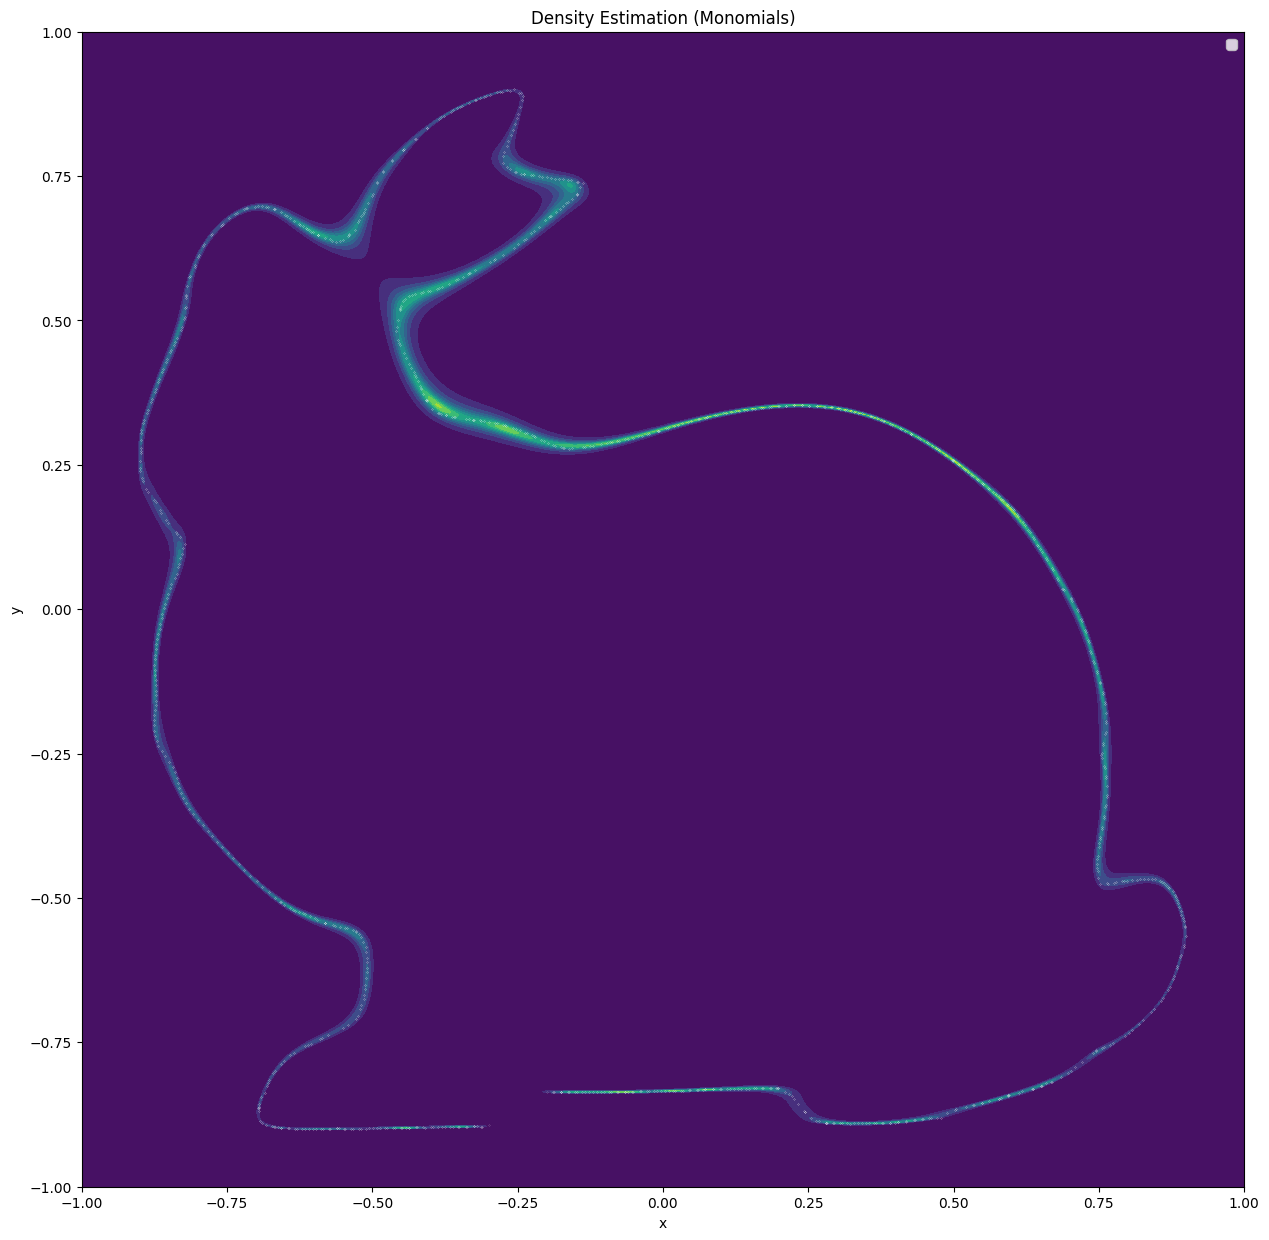

In [21]:
# Set the degree of polynomials
degree = 30
# Approximate density
xx, yy, density = approximate_density(pcl, degree, poly=generate_monomials, grid_size=1000, reg=1e-12)
print(density.max(), density.min())
# Plot the level sets of the density
plt.figure(figsize=(15,15))
plt.contourf(xx, yy, density, levels=10)
plt.scatter(pcl[:, 0], pcl[:, 1], s=0.01, color='white')
plt.legend()
plt.title('Density Estimation (Monomials)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Number of Chebyshev polynomials: 253
Time for covariance computation: 0.00s
Time for Cholesky decomposition: 0.00s
Time for Cholesky inverse computation: 0.00s
Number of Chebyshev polynomials: 253


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Time for Christoffel function computation: 0.58s


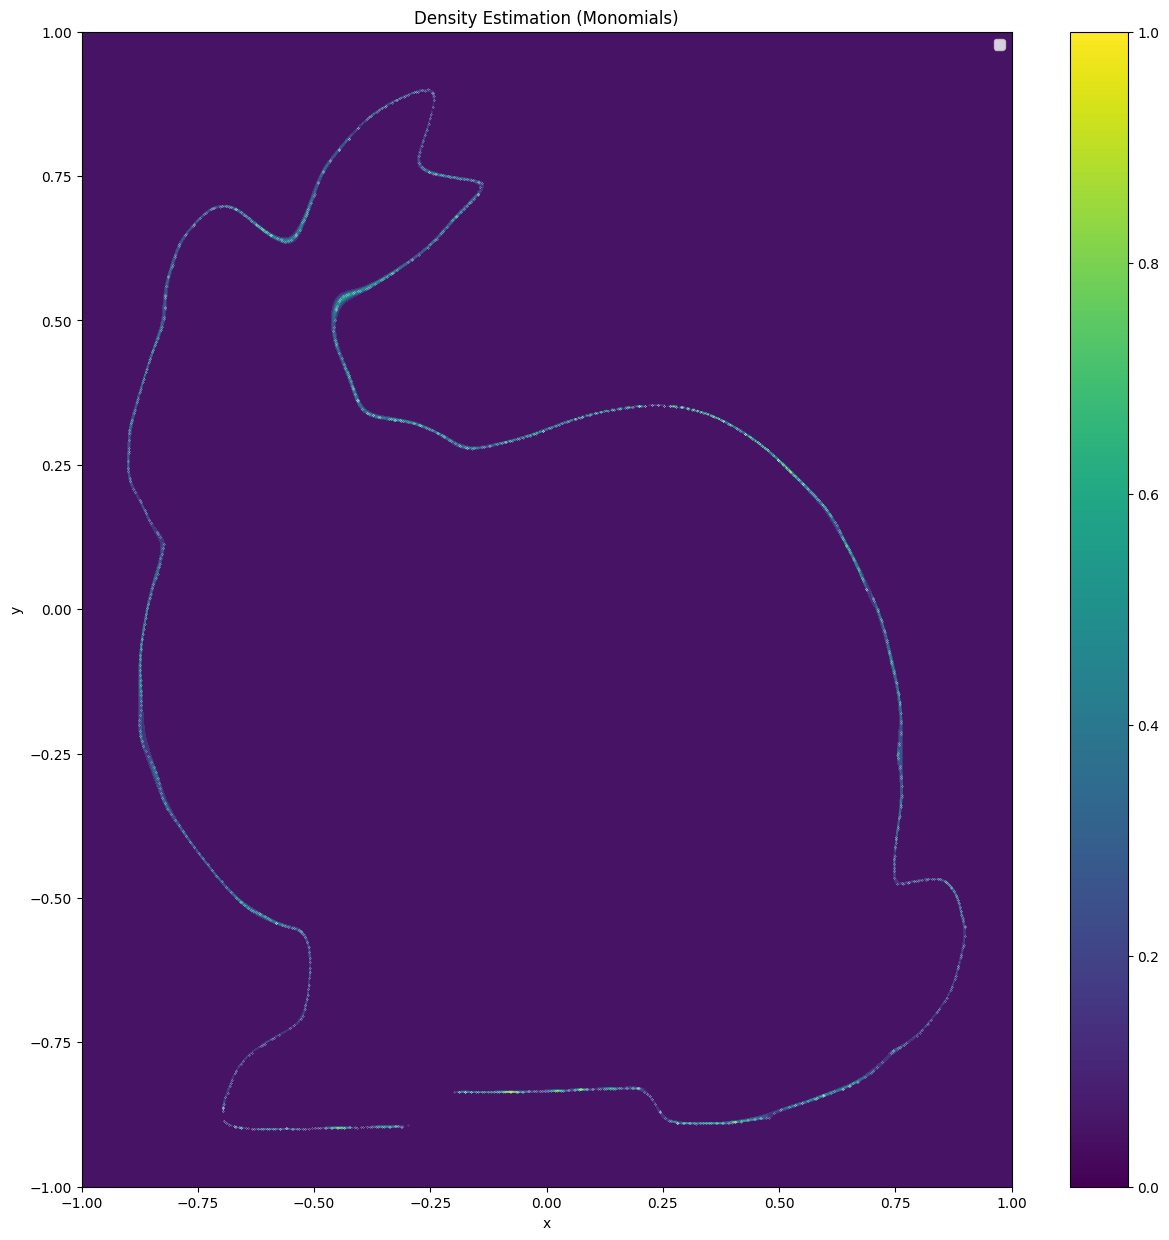

In [24]:
# Set the degree of polynomials
degree = 21
# Approximate density
xx, yy, density = approximate_density(pcl, degree, poly=generate_chebyshev_polynomials, grid_size=1000, reg=1e-12)
# print(density.max(), density.min())
# Plot the level sets of the density
plt.figure(figsize=(15,15))
plt.contourf(xx, yy, density, levels=10)
plt.scatter(pcl[:, 0], pcl[:, 1], s=0.01, color='white')
plt.legend()
plt.colorbar()
plt.title('Density Estimation (Monomials)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()